# **데이터 불러오기**

In [16]:
import pandas as pd
import numpy as np
from time import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

scaler = StandardScaler()

early_stopping = EarlyStopping()

train_features=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

train_features = train_features.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
train_features = train_features.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
train_features = train_features.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))

test = test.assign(loc = lambda x: np.hypot(np.hypot(x['gy_x'],x['gy_y']),x['gy_z']))
test = test.assign(acc = lambda x: np.hypot(np.hypot(x['acc_x'],x['acc_y']),x['acc_z']))
test = test.assign(move = lambda x: np.sqrt(np.sqrt(x['gy_x']**2+x['acc_x']**2)**2+np.sqrt(x['gy_y']**2+x['acc_y']**2)**2+np.sqrt(x['gy_z']**2+x['acc_z']**2)**2))
start = time()

x_train = []

train_features.shape

for uid in tqdm(train_features['id'].unique()):
    temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
    x_train.append(temp)

x_train = np.array(x_train, np.float32)

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32).T
    x_test.append(temp)

x_test = np.array(x_test, np.float32)


100%|██████████| 782/782 [00:00<00:00, 940.34it/s]


In [33]:
def aug(data, uid, shift = 0):
    shift_data = np.roll(data, shift, axis=2)
    
for _ in range(10):
    aug(x_train, 0, int(random.random()*600))
X = x_train
X=tf.reshape(x_train,[-1, 600,6])
X.shape

TensorShape([3125, 600, 6])

In [34]:
y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape

(3125, 61)

In [26]:
from tensorflow.keras.layers import Dropout,Flatten

In [35]:
#가벼운 모델 생성
model = Sequential()
model.add(LSTM(64,input_shape=(600,6)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(61, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
history = model.fit(X,y, epochs=100, batch_size=64, validation_split=0.2)

Epoch 1/100
40/40 [==============================] - 3s 41ms/step - loss: 3.5611 - accuracy: 0.3322 - val_loss: 2.7457 - val_accuracy: 0.4976
Epoch 2/100
40/40 [==============================] - 1s 33ms/step - loss: 2.9547 - accuracy: 0.4591 - val_loss: 2.6388 - val_accuracy: 0.4976
Epoch 3/100
40/40 [==============================] - 1s 31ms/step - loss: 2.8111 - accuracy: 0.4697 - val_loss: 2.5755 - val_accuracy: 0.5024
Epoch 4/100
40/40 [==============================] - 1s 31ms/step - loss: 2.6608 - accuracy: 0.4910 - val_loss: 2.5642 - val_accuracy: 0.4992
Epoch 5/100
40/40 [==============================] - 1s 35ms/step - loss: 2.6013 - accuracy: 0.4914 - val_loss: 2.5333 - val_accuracy: 0.5104
Epoch 6/100
40/40 [==============================] - 1s 31ms/step - loss: 2.6590 - accuracy: 0.4744 - val_loss: 2.5133 - val_accuracy: 0.5040
Epoch 7/100
40/40 [==============================] - 1s 31ms/step - loss: 2.6096 - accuracy: 0.4699 - val_loss: 2.4755 - val_accuracy: 0.5200
Epoch 


When hidden layers are 2, Elapse training time : 303.50890851020813 seconds

98/98 [==============================] - 1s 12ms/step - loss: 1.1501 - accuracy: 0.7021

Loss : 1.1501
Accuracy : 70.208%
When hidden layers are 2, Elapse test time : 1.186213493347168 seconds


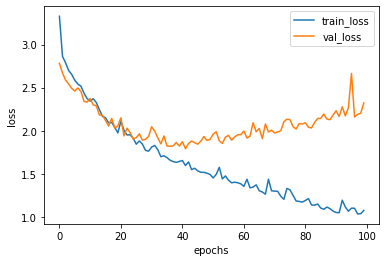

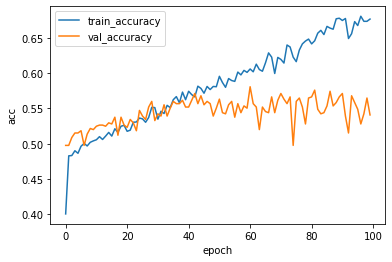

In [32]:
print(f'\nWhen hidden layers are 2, Elapse training time : {time() - start} seconds\n')
start = time()
loss_and_metrics = model.evaluate(X, y)
print(f'\nLoss : {loss_and_metrics[0]:.6}')
print(f'Accuracy : {loss_and_metrics[1]*100:.6}%')
print(f'When hidden layers are 2, Elapse test time : {time() - start} seconds')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [48]:
test_X=tf.reshape(np.array(test.iloc[:,2:]),[-1, 6,600])
test_X.shape

TensorShape([782, 6, 600])

In [49]:
prediction=model.predict(test_X)

In [50]:
prediction.shape

(782, 61)

In [51]:
submission

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
submission.iloc[:,1:]=prediction

In [53]:
submission

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000071,5.806910e-05,4.499830e-07,0.000019,0.000170,0.000513,0.000009,0.000005,1.593359e-08,...,5.518789e-07,2.646468e-08,2.338895e-06,1.500934e-06,1.198941e-07,1.697690e-05,5.934605e-04,8.659116e-08,2.142212e-07,1.736271e-05
1,3126,0.000106,2.923123e-02,3.722803e-03,0.001843,0.002112,0.001931,0.007649,0.050970,3.453573e-03,...,1.422525e-04,3.246478e-04,3.860026e-04,3.980402e-03,2.178300e-04,4.110748e-04,2.806450e-03,7.481649e-06,1.754814e-04,6.559184e-04
2,3127,0.000020,5.092921e-05,1.595063e-05,0.000065,0.000446,0.029723,0.000062,0.000052,1.261594e-05,...,6.349880e-06,1.331533e-05,1.602283e-04,4.846647e-05,1.254044e-06,2.443306e-04,4.131020e-04,7.161370e-07,2.175943e-05,2.737284e-04
3,3128,0.000046,3.296949e-07,1.075878e-08,0.000001,0.000013,0.000006,0.000002,0.000010,5.953875e-12,...,6.128790e-09,8.116343e-12,8.016963e-09,9.645026e-10,6.212986e-11,2.299372e-08,1.853632e-05,2.507429e-07,7.073843e-08,4.976548e-06
4,3129,0.000006,2.587856e-02,1.353221e-06,0.000123,0.000074,0.000488,0.000003,0.000121,1.494408e-02,...,4.841115e-04,6.113031e-04,1.284108e-06,6.865948e-04,4.198064e-06,3.943737e-05,5.895081e-03,4.406104e-08,5.016463e-06,1.849098e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.000013,7.485919e-06,2.044113e-07,0.000007,0.000006,0.000710,0.000018,0.000015,1.361743e-07,...,9.967931e-06,5.178075e-08,8.191682e-06,1.458885e-04,1.627037e-08,1.032273e-04,3.962327e-04,7.120118e-08,2.974170e-08,6.553962e-04
778,3903,0.014643,1.845944e-02,6.755095e-04,0.003866,0.001332,0.036516,0.000498,0.010218,1.727912e-07,...,1.368428e-04,2.002022e-07,1.637228e-05,2.124739e-04,1.901820e-06,1.706268e-03,4.580948e-05,3.160819e-05,2.269893e-02,3.170330e-04
779,3904,0.001467,2.661686e-05,2.111320e-05,0.000038,0.000054,0.001495,0.000203,0.000148,7.962742e-11,...,3.799105e-08,1.222327e-10,1.136144e-06,2.092368e-07,1.813627e-08,5.375270e-06,2.417639e-07,7.860422e-06,7.991027e-07,7.994895e-08
780,3905,0.016321,4.100325e-05,7.026815e-04,0.013747,0.006802,0.116663,0.000004,0.001202,3.075182e-10,...,3.894119e-03,3.880520e-06,9.275865e-03,4.817062e-06,2.519677e-01,1.509172e-01,5.818166e-04,1.257424e-03,6.461455e-03,5.691008e-06


In [54]:
submission.to_csv('submission.csv', index=False)